<a href="https://colab.research.google.com/github/datav1per/Crypto-currencies-Prediction/blob/main/cryptocurrency_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Information we put:
1. Time series nature: Crypto prices depend on previous trends, requiring sequential modeling.

2. Volatility awareness: Cryptocurrencies show high non-linear volatility → LSTM chosen over linear models.

3. Scaling importance: Used MinMaxScaler to normalize prices for stable neural network training.

4. Forecasting approach: Used previous 60 days to predict next day, aligning with trading strategies.

5. Evaluation metrics: RMSE & MAE chosen for clear financial interpretability.

6. Data sufficiency: Skipped cryptos with insufficient data to ensure meaningful modeling.

In [2]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# Load dataset
crypto = pd.read_csv('/content/crypto-markets.csv')

# EDA


In [4]:
# EDA
crypto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102132 entries, 0 to 102131
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   slug         102132 non-null  object 
 1   symbol       102132 non-null  object 
 2   name         102131 non-null  object 
 3   date         102131 non-null  object 
 4   ranknow      102131 non-null  float64
 5   open         102131 non-null  float64
 6   high         102131 non-null  float64
 7   low          102131 non-null  float64
 8   close        102131 non-null  float64
 9   volume       102131 non-null  float64
 10  market       102131 non-null  float64
 11  close_ratio  102131 non-null  float64
 12  spread       102131 non-null  float64
dtypes: float64(9), object(4)
memory usage: 10.1+ MB


In [5]:
# Check zero counts
print("Volume zeros:", (crypto['volume'] == 0).sum())
print("Spread zeros:", (crypto['spread'] == 0).sum())


Volume zeros: 958
Spread zeros: 28627


In [6]:
cols_to_fix = ['volume', 'spread']
crypto[cols_to_fix] = crypto[cols_to_fix].replace(0, np.nan)


In [7]:
crypto.dropna(subset=cols_to_fix, inplace=True)
crypto[cols_to_fix] = crypto[cols_to_fix].fillna(method='ffill')


/tmp/ipython-input-7-1643450661.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crypto[cols_to_fix] = crypto[cols_to_fix].fillna(method='ffill')


In [8]:
(crypto[['open','high','low','close','volume','market']] < 0).sum()


,0
open,0
high,0
low,0
close,0
volume,0
market,0


In [9]:
crypto.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
243,bitcoin,BTC,Bitcoin,2013-12-27,1.0,763.28,777.51,713.60,735.07,46862700.0,8.955395e+09,0.3359,63.91
244,bitcoin,BTC,Bitcoin,2013-12-28,1.0,737.98,747.06,705.35,727.83,32505800.0,8.869919e+09,0.5390,41.71
245,bitcoin,BTC,Bitcoin,2013-12-29,1.0,728.05,748.61,714.44,745.05,19011300.0,9.082104e+09,0.8958,34.17
246,bitcoin,BTC,Bitcoin,2013-12-30,1.0,741.35,766.60,740.24,756.13,20707700.0,9.217168e+09,0.6028,26.36
247,bitcoin,BTC,Bitcoin,2013-12-31,1.0,760.32,760.58,738.17,754.01,20897300.0,9.191325e+09,0.7068,22.41


In [10]:
crypto['volume'].isnull()

,volume
243,False
244,False
245,False
246,False
247,False
...,...
102125,False
102126,False
102127,False
102128,False


In [11]:
crypto.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread
count,72737.000000,72737.000000,72737.000000,72737.000000,72737.000000,7.273700e+04,7.273700e+04,72737.000000,72737.000000
mean,76.836947,95.332577,99.243458,91.067300,95.270711,1.058611e+08,2.113723e+09,0.488856,8.176323
std,53.441298,699.789780,724.979309,669.907132,699.673024,6.534071e+08,1.270527e+10,0.299521,70.634182
min,1.000000,0.000353,0.006660,0.000234,0.000234,1.000000e+00,0.000000e+00,0.000000,0.010000
25%,28.000000,0.327030,0.348547,0.305251,0.326794,5.255110e+05,3.823413e+07,0.228300,0.030000
50%,71.000000,1.290000,1.370000,1.190000,1.290000,2.912140e+06,1.201198e+08,0.480800,0.130000
75%,123.000000,7.280000,7.800000,6.780000,7.280000,1.591350e+07,3.827679e+08,0.749700,0.780000
max,176.000000,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.265025e+11,1.000000,4110.400000


In [12]:
crypto.duplicated().sum()

np.int64(0)

In [13]:
b=crypto['symbol'].nunique()
b

170

In [14]:
crypto['date'] = pd.to_datetime(crypto['date'])
print(crypto['date'].min(), crypto['date'].max())

2013-12-27 00:00:00 2018-11-29 00:00:00


In [15]:
crypto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72737 entries, 243 to 102130
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   slug         72737 non-null  object        
 1   symbol       72737 non-null  object        
 2   name         72737 non-null  object        
 3   date         72737 non-null  datetime64[ns]
 4   ranknow      72737 non-null  float64       
 5   open         72737 non-null  float64       
 6   high         72737 non-null  float64       
 7   low          72737 non-null  float64       
 8   close        72737 non-null  float64       
 9   volume       72737 non-null  float64       
 10  market       72737 non-null  float64       
 11  close_ratio  72737 non-null  float64       
 12  spread       72737 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(3)
memory usage: 9.8+ MB


THe data of all cryptocurrency is distributed from 2013-2018


# Bitcoin (BTC) Time-series Analysis: It has the highest market dominance.

Testing the model on one cryptocurrency cause:
1. Data preprocessing steps were correct.
2. Testing model with one then moving on to others
3. Evaluation metrics like RMSE and MAE made sense before generalising.


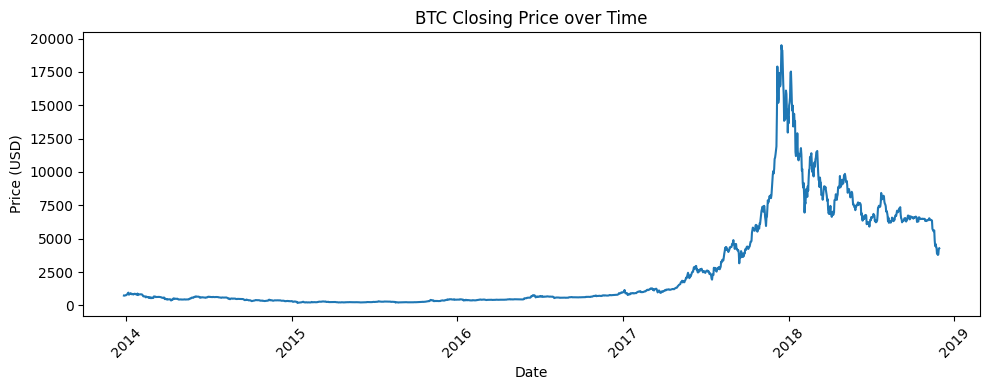

In [16]:
# Filter for Bitcoin (BTC)
btc = crypto[crypto['symbol'] == 'BTC'].copy()

btc = btc[['date', 'close']]

# Convert dates of BTC symbol to datetime as it was in object
btc = btc.sort_values('date')
btc = btc[btc['close'] > 0]

# Drop missing values in case any.
btc.dropna(inplace=True)
btc.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10,4))
plt.plot(btc['date'], btc['close'])
plt.title('BTC Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1799 non-null   datetime64[ns]
 1   open    1799 non-null   float64       
 2   close   1799 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 42.3 KB
None
        date    open   close
0 2013-12-27  763.28  735.07
1 2013-12-28  737.98  727.83
2 2013-12-29  728.05  745.05
3 2013-12-30  741.35  756.13
4 2013-12-31  760.32  754.01


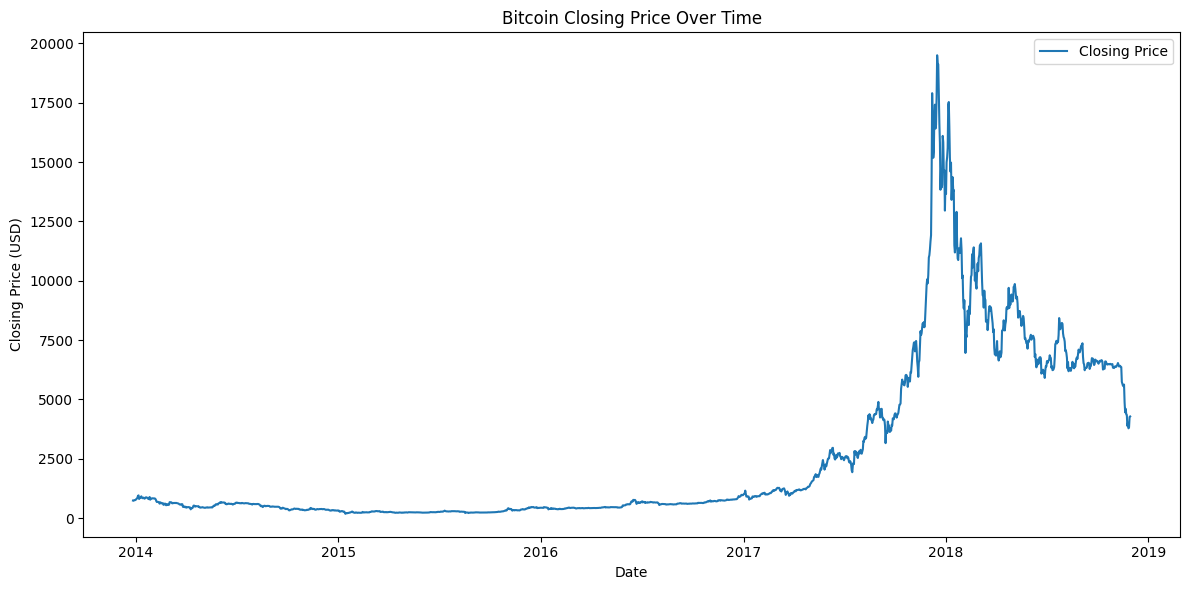

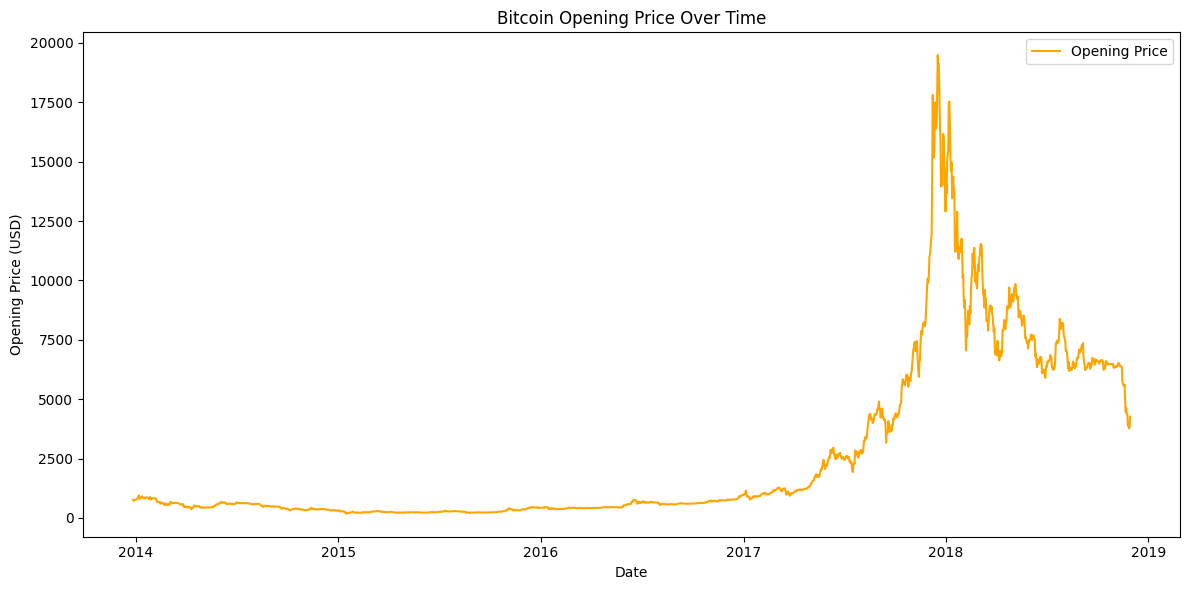

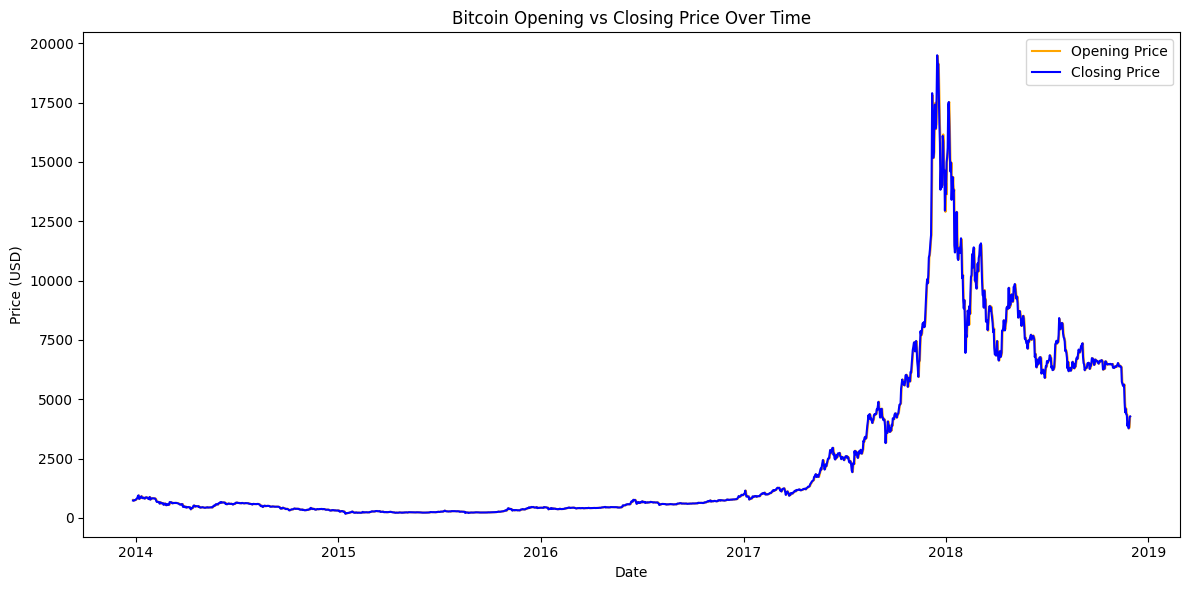

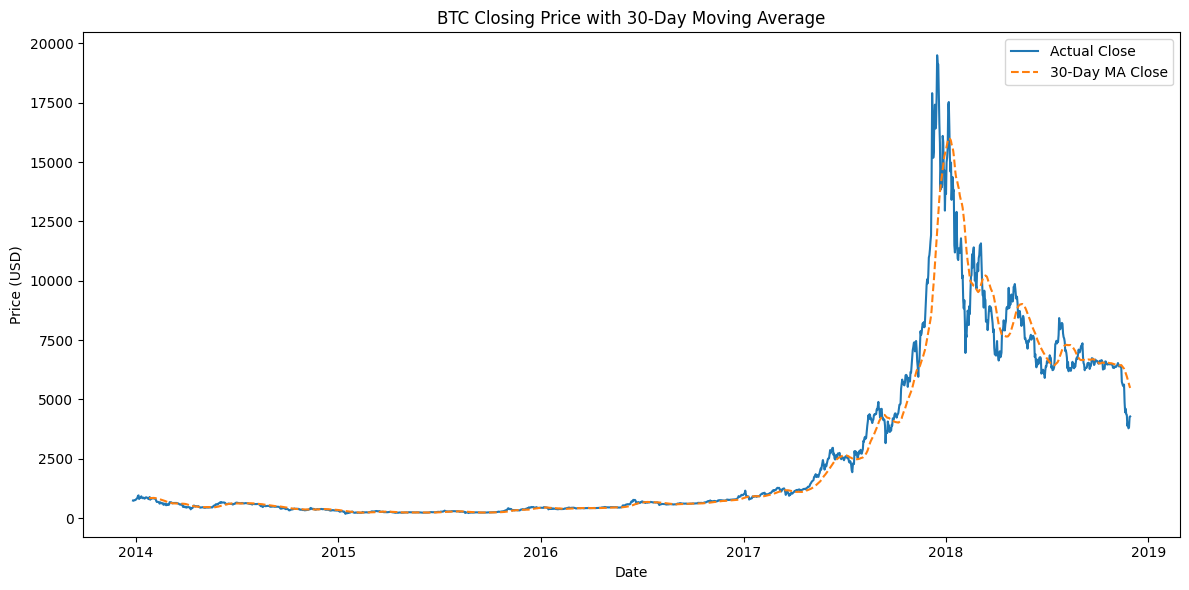

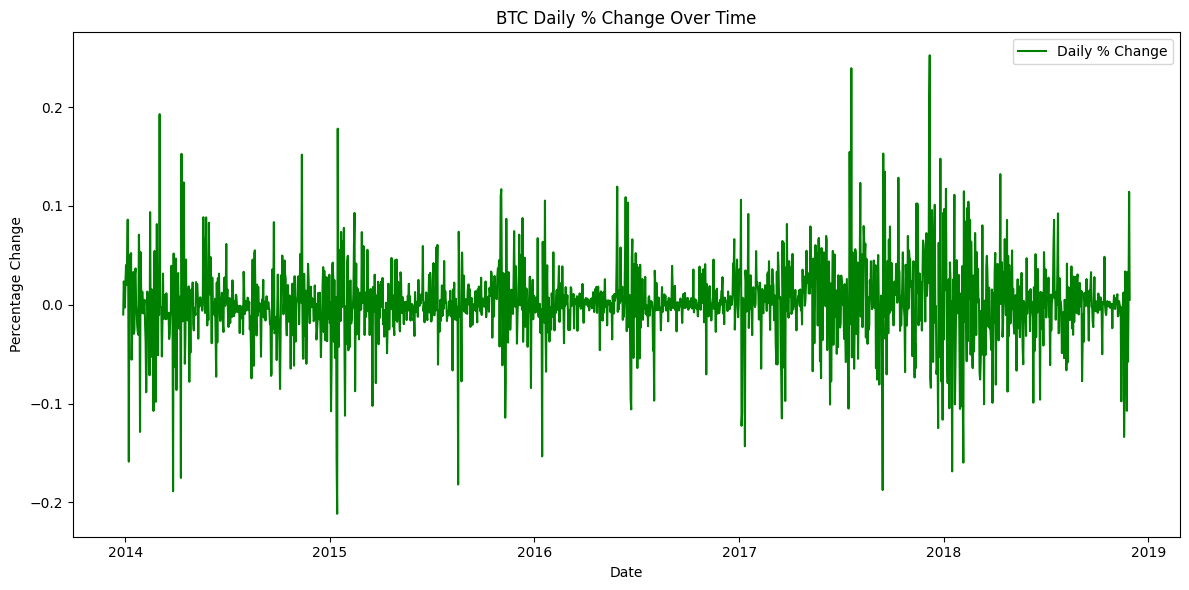

In [17]:
# Filter the dataset to include only Bitcoin (BTC) rows with 'open' and 'close' prices
btc = crypto[crypto['symbol'] == 'BTC'].copy()
btc = btc[['date', 'open', 'close']]

# Convert the 'date' column to datetime format and sort the data in chronological order
btc['date'] = pd.to_datetime(btc['date'])
btc = btc.sort_values('date').dropna().reset_index(drop=True)

# Check the basic information and preview the top rows to understand the data structure
print(btc.info())
print(btc.head())

# Plot the closing price of BTC over time to see overall trends
plt.figure(figsize=(12,6))
plt.plot(btc['date'], btc['close'], label='Closing Price')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the opening price of BTC over time to observe how it starts each day
plt.figure(figsize=(12,6))
plt.plot(btc['date'], btc['open'], label='Opening Price', color='orange')
plt.title('Bitcoin Opening Price Over Time')
plt.xlabel('Date')
plt.ylabel('Opening Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot both opening and closing prices together for easy comparison of daily price movement
plt.figure(figsize=(12,6))
plt.plot(btc['date'], btc['open'], label='Opening Price', color='orange')
plt.plot(btc['date'], btc['close'], label='Closing Price', color='blue')
plt.title('Bitcoin Opening vs Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate the 30-day moving average of the closing price to smooth out daily fluctuations
btc['MA30_Close'] = btc['close'].rolling(window=30).mean()

# Plot the actual closing price along with its 30-day moving average to visualize trends clearly
plt.figure(figsize=(12,6))
plt.plot(btc['date'], btc['close'], label='Actual Close')
plt.plot(btc['date'], btc['MA30_Close'], label='30-Day MA Close', linestyle='--')
plt.title('BTC Closing Price with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

btc['pct_change'] = btc['close'].pct_change()

# Plot the daily percentage change over time
plt.figure(figsize=(12,6))
plt.plot(btc['date'], btc['pct_change'], label='Daily % Change', color='green')
plt.title('BTC Daily % Change Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
# Extract the closing prices as a NumPy array and reshape it to a 2D array for scaling
close_prices = btc['close'].values.reshape(-1,1)

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)


In [19]:
# Create sequences of length seq_length for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_prices, seq_length)

# Reshape for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)


In [20]:
# Split data into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [21]:
# Build the LSTM model for BTC price prediction
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile with Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 3.9226e-04 - val_loss: 0.0088
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 4.4838e-05 - val_loss: 0.0059
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 3.0295e-05 - val_loss: 0.0048
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 3.5462e-05 - val_loss: 0.0075
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 2.7696e-05 - val_loss: 0.0051
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 2.8250e-05 - val_loss: 0.0042
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 2.6122e-05 - val_loss: 0.0071
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 4.1731e-05 - val_loss: 0.0046
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 3.7228e-05 - val_loss: 0.0052
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 2.9455e-05 - val_loss: 0.0032
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 2.8110e-05 - val_loss: 0.0048
Epoch 12/100
40/40 ━

In [22]:
predictions = model.predict(X_test)
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [23]:
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


RMSE: 893.71
MAE: 642.84
MAPE: 7.81%


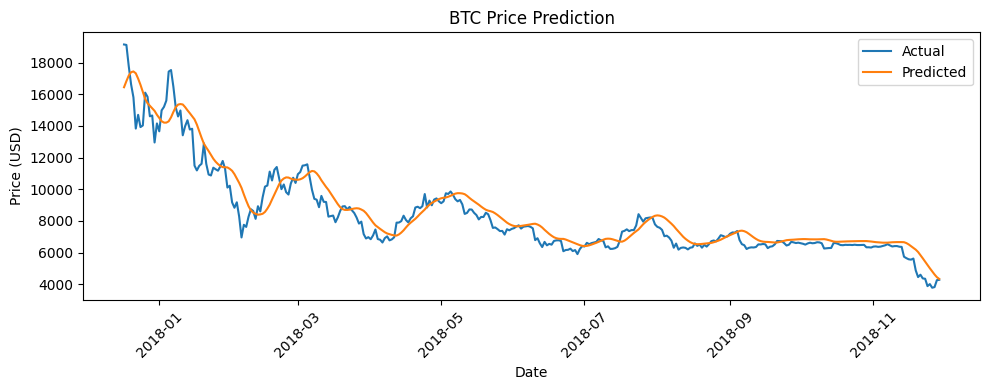

In [24]:
#Plot graph
plt.figure(figsize=(10,4))
plt.plot(btc['date'].values[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(btc['date'].values[-len(predictions_actual):], predictions_actual, label='Predicted')
plt.title('BTC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

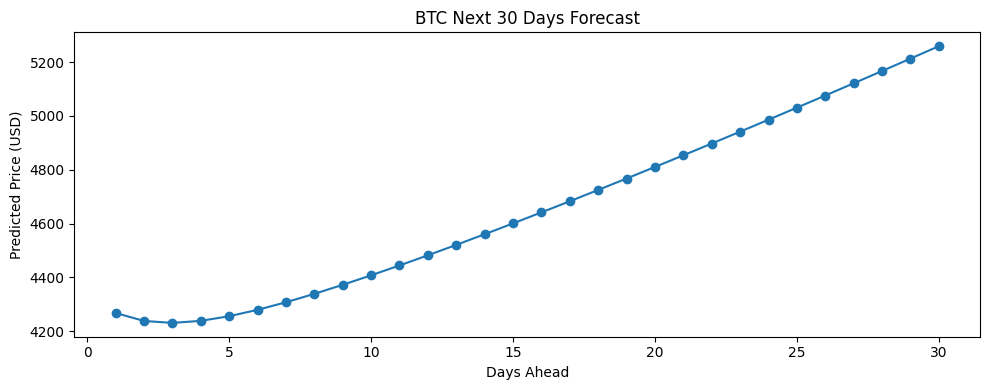

In [25]:
last_seq = scaled_prices[-seq_length:]
future_preds = []

input_seq = last_seq.reshape(1, seq_length, 1)

for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

# Inverse transform
future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

# Plot
plt.figure(figsize=(10,4))
plt.plot(range(1,31), future_prices, marker='o')
plt.title('BTC Next 30 Days Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted Price (USD)')
plt.tight_layout()
plt.show()


# Other Cryptocurrency Predictions


After verifying the model on BTC, I extended it to 5 more cryptocurrencies because of system crash with all 2005 symbols


I Selected only the first 5 to:
1. To avoid system crash, RAM overuse
2. Model preparation for getting prediction for the symbols we write.
3. Compare RMSE, MAE and MAPE for multiple symbols efficiently.


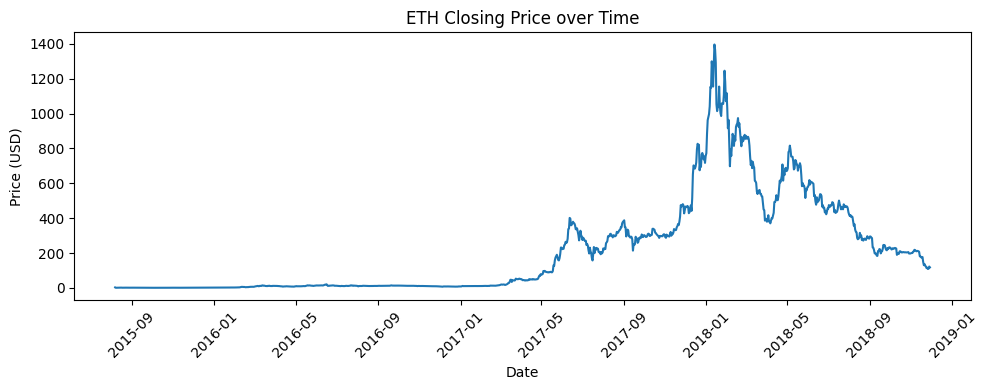

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0149 - val_loss: 0.0463
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0013 - val_loss: 0.0842
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 8.8397e-04 - val_loss: 0.0748
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 8.8534e-04 - val_loss: 0.0629
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 8.2958e-04 - val_loss: 0.1356
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0018 - val_loss: 0.0643
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 9.6106e-04 - val_loss: 0.0327
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.7857e-04 - val_loss: 0.0342
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0013 - val_loss: 0.0695
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 8.3918e-04 - val_loss: 0.0670
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 8.3078e-04 - val_loss: 0.0524
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━

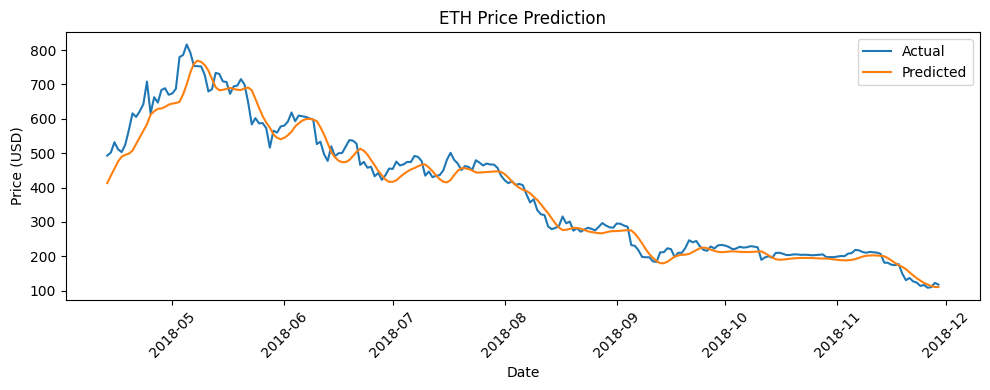

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

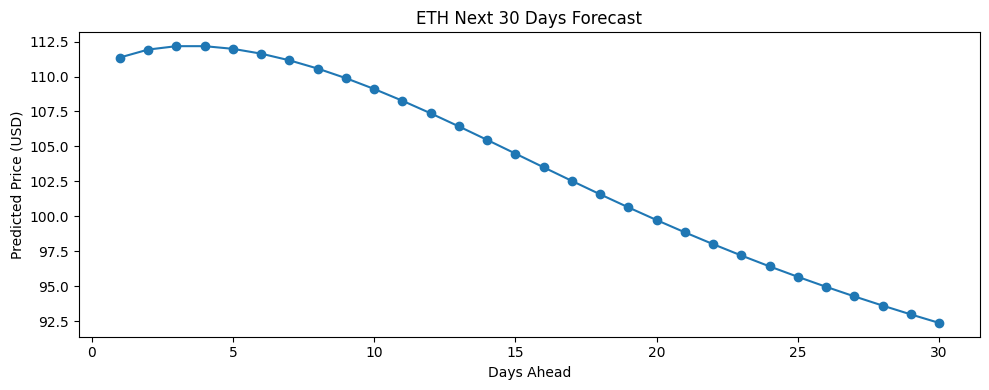

In [26]:
# Filter for Ethereum (ETH)
eth = crypto[crypto['symbol'] == 'ETH'].copy()
eth = eth[['date', 'close']]
eth = eth.sort_values('date')
eth = eth[eth['close'] > 0].dropna().reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.plot(eth['date'], eth['close'])
plt.title('ETH Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

close_prices = eth['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

X, y = create_sequences(scaled_prices, 60)
X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

predictions = model.predict(X_test)
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100

print(f"ETH RMSE: {rmse:.2f}")
print(f"ETH MAE: {mae:.2f}")
print(f"ETH MAPE: {mape:.2f}%")

plt.figure(figsize=(10,4))
plt.plot(eth['date'].values[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(eth['date'].values[-len(predictions_actual):], predictions_actual, label='Predicted')
plt.title('ETH Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Next 30 days forecast
last_seq = scaled_prices[-60:]
future_preds = []
input_seq = last_seq.reshape(1, 60, 1)

for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

plt.figure(figsize=(10,4))
plt.plot(range(1,31), future_prices, marker='o')
plt.title('ETH Next 30 Days Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted Price (USD)')
plt.tight_layout()
plt.show()


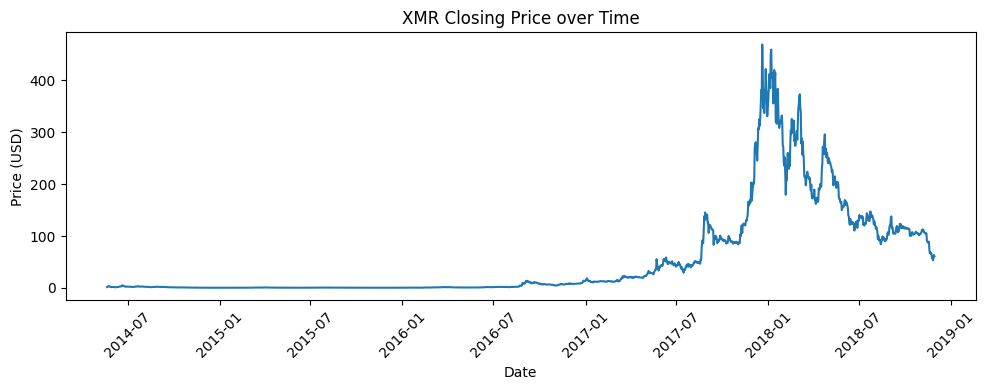

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0012 - val_loss: 0.0073
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 8.1910e-05 - val_loss: 0.0089
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.7109e-04 - val_loss: 0.0043
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.5410e-04 - val_loss: 0.0038
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.1650e-04 - val_loss: 0.0036
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.2519e-04 - val_loss: 0.0036
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 6.3328e-05 - val_loss: 0.0068
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 1.0895e-04 - val_loss: 0.0043
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 9.0303e-05 - val_loss: 0.0034
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 1.8229e-04 - val_loss: 0.0045
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 1.5161e-04 - val_loss: 0.0080
Epoch 12/100
36/36 ━━━━━

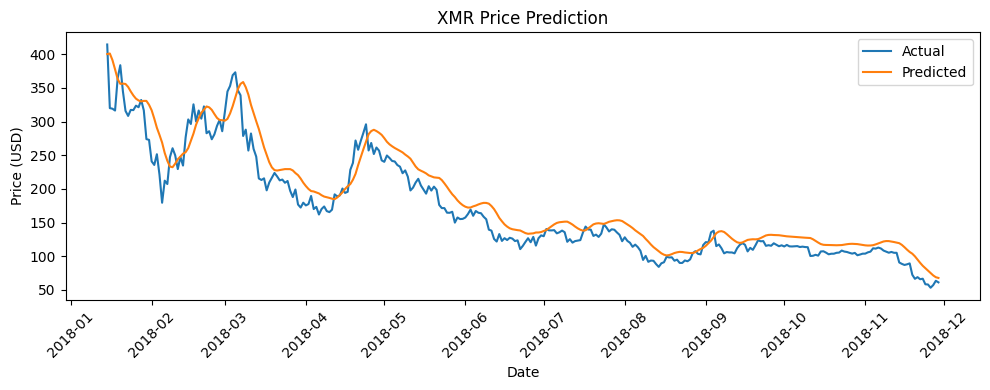

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

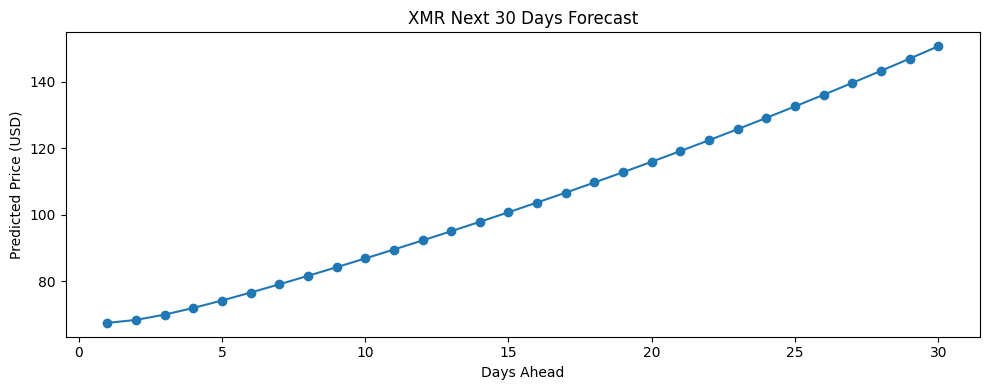

In [27]:
# Filter for Monero (XMR)
xmr = crypto[crypto['symbol'] == 'XMR'].copy()
xmr = xmr[['date', 'close']]
xmr = xmr.sort_values('date')
xmr = xmr[xmr['close'] > 0].dropna().reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.plot(xmr['date'], xmr['close'])
plt.title('XMR Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

close_prices = xmr['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

X, y = create_sequences(scaled_prices, 60)
X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

predictions = model.predict(X_test)
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100

print(f"XMR RMSE: {rmse:.2f}")
print(f"XMR MAE: {mae:.2f}")
print(f"XMR MAPE: {mape:.2f}%")

plt.figure(figsize=(10,4))
plt.plot(xmr['date'].values[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(xmr['date'].values[-len(predictions_actual):], predictions_actual, label='Predicted')
plt.title('XMR Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Next 30 days forecast
last_seq = scaled_prices[-60:]
future_preds = []
input_seq = last_seq.reshape(1, 60, 1)

for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

plt.figure(figsize=(10,4))
plt.plot(range(1,31), future_prices, marker='o')
plt.title('XMR Next 30 Days Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted Price (USD)')
plt.tight_layout()
plt.show()


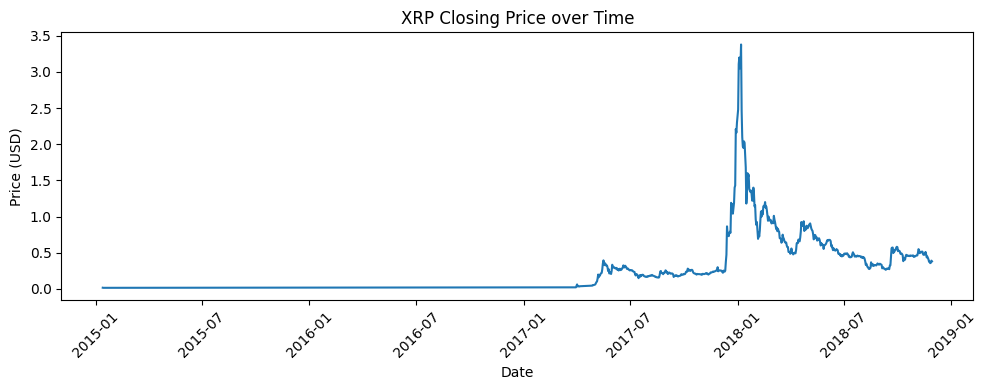

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0313 - val_loss: 0.0035
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0089 - val_loss: 4.3949e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0062 - val_loss: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0062 - val_loss: 1.5965e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0044 - val_loss: 3.9802e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0052 - val_loss: 1.5845e-04
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0050 - val_loss: 1.2808e-04
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0034 - val_loss: 1.2958e-04
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0048 - val_loss: 1.1396e-04
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0036 - val_loss: 3.2881e-04
Epoch 12/100
12/12 ━━━━━━━━━━━━

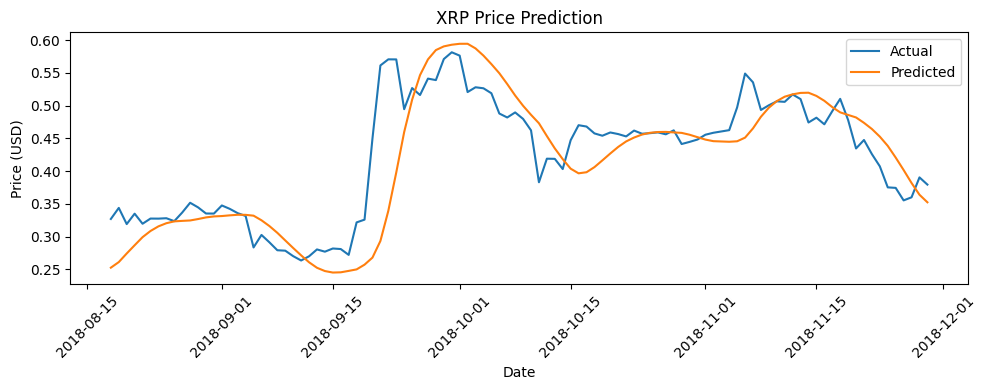

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

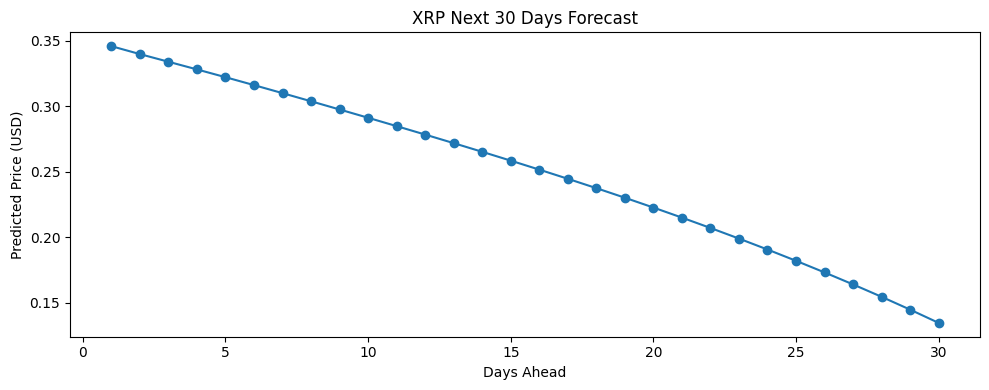

In [28]:
# Filter for Ripple (XRP)
xrp = crypto[crypto['symbol'] == 'XRP'].copy()
xrp = xrp[['date', 'close']]
xrp = xrp.sort_values('date')
xrp = xrp[xrp['close'] > 0]
xrp.dropna(inplace=True)
xrp.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10,4))
plt.plot(xrp['date'], xrp['close'])
plt.title('XRP Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

close_prices = xrp['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

X, y = create_sequences(scaled_prices, 60)
X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

predictions = model.predict(X_test)
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100

print(f"XRP RMSE: {rmse:.2f}")
print(f"XRP MAE: {mae:.2f}")
print(f"XRP MAPE: {mape:.2f}%")

# Plot predictions vs actual
plt.figure(figsize=(10,4))
plt.plot(xrp['date'].values[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(xrp['date'].values[-len(predictions_actual):], predictions_actual, label='Predicted')
plt.title('XRP Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Future forecast next 30 days
last_seq = scaled_prices[-60:]
future_preds = []

input_seq = last_seq.reshape(1, 60, 1)

for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

plt.figure(figsize=(10,4))
plt.plot(range(1,31), future_prices, marker='o')
plt.title('XRP Next 30 Days Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted Price (USD)')
plt.tight_layout()
plt.show()


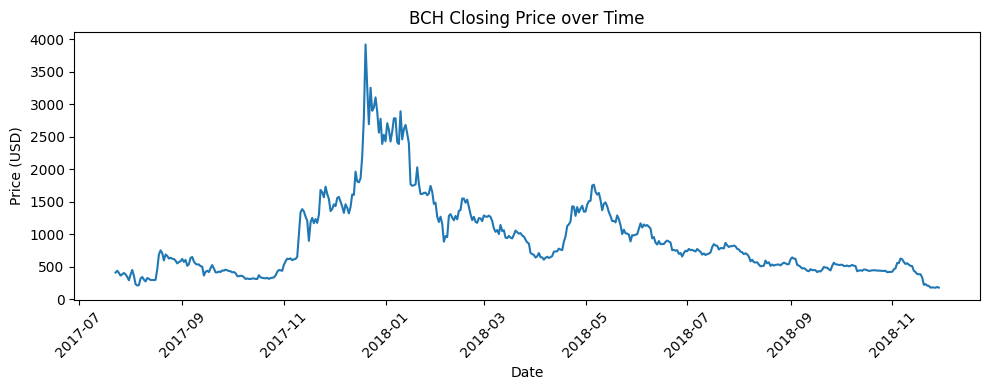

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0888 - val_loss: 0.0167
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0158 - val_loss: 0.0031
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0110 - val_loss: 0.0035
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0075 - val_loss: 0.0026
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0078 - val_loss: 0.0014
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0046 - val_loss: 9.9761e-04
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0060 - val_loss: 0.0010
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - los

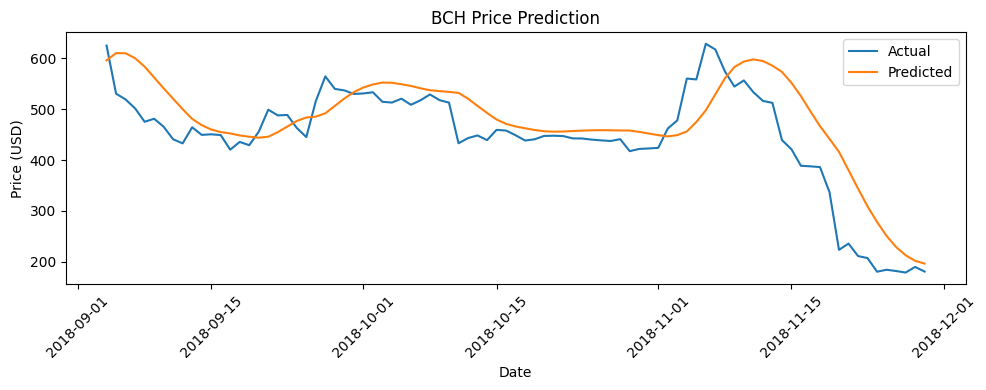

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

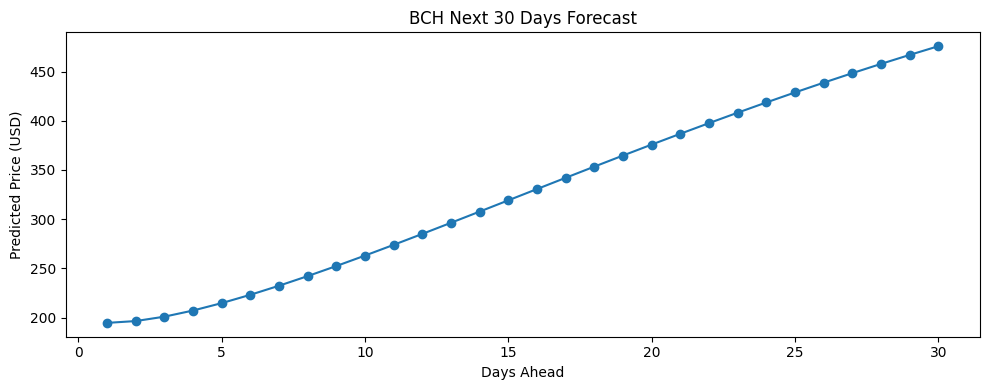

In [29]:
# Filter for Bitcoin Cash (BCH)
bch = crypto[crypto['symbol'] == 'BCH'].copy()
bch = bch[['date', 'close']]
bch = bch.sort_values('date')
bch = bch[bch['close'] > 0]
bch.dropna(inplace=True)
bch.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10,4))
plt.plot(bch['date'], bch['close'])
plt.title('BCH Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

close_prices = bch['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

X, y = create_sequences(scaled_prices, 60)
X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

predictions = model.predict(X_test)
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100

print(f"BCH RMSE: {rmse:.2f}")
print(f"BCH MAE: {mae:.2f}")
print(f"BCH MAPE: {mape:.2f}%")

# Plot predictions vs actual
plt.figure(figsize=(10,4))
plt.plot(bch['date'].values[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(bch['date'].values[-len(predictions_actual):], predictions_actual, label='Predicted')
plt.title('BCH Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Future forecast next 30 days
last_seq = scaled_prices[-60:]
future_preds = []

input_seq = last_seq.reshape(1, 60, 1)

for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

plt.figure(figsize=(10,4))
plt.plot(range(1,31), future_prices, marker='o')
plt.title('BCH Next 30 Days Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted Price (USD)')
plt.tight_layout()
plt.show()


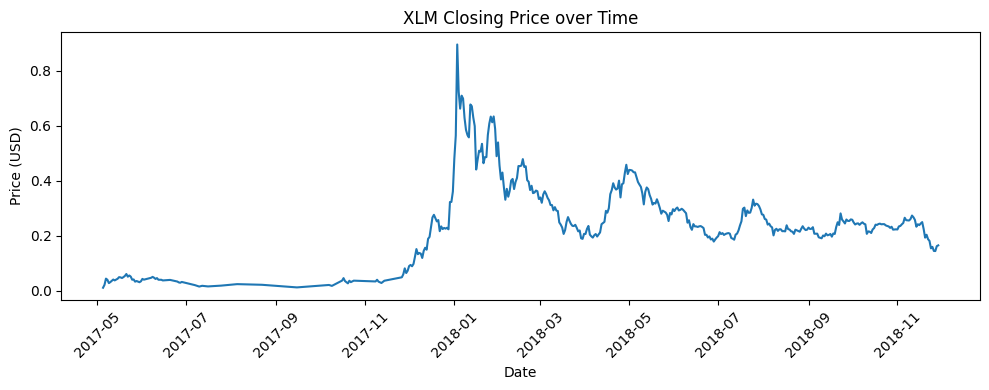

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0731 - val_loss: 0.0135
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0174 - val_loss: 2.1752e-04
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0162 - val_loss: 0.0027
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0083 - val_loss: 0.0025
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0104 - val_loss: 5.9717e-04
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0086 - val_loss: 0.0013
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0086 - val_loss: 5.9571e-04
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0081 - val_loss: 8.0727e-04
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0067 - val_loss: 8.6141e-04
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0085 - val_loss: 7.3080e-04
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0094 - val_loss: 4.6993e-04
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss

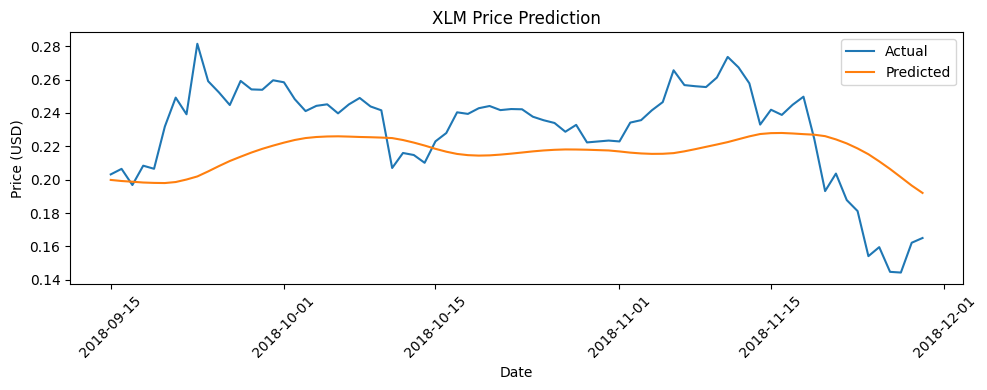

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

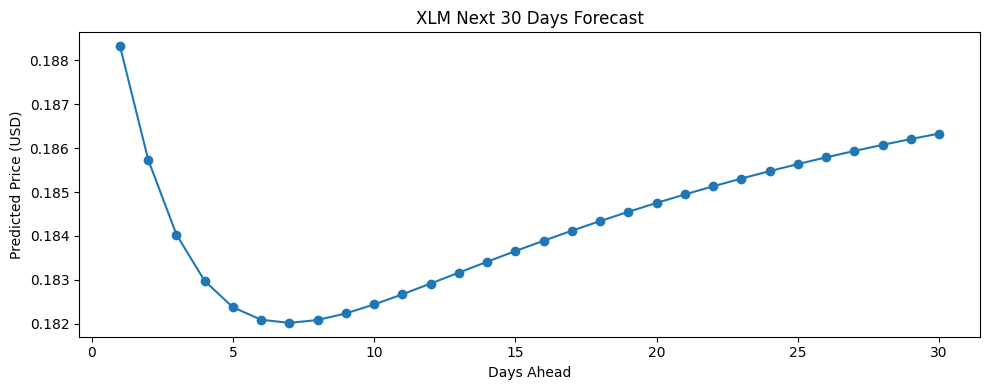

In [30]:
# Filter for Stellar (XLM)
xlm = crypto[crypto['symbol'] == 'XLM'].copy()
xlm = xlm[['date', 'close']]
xlm = xlm.sort_values('date')
xlm = xlm[xlm['close'] > 0]
xlm.dropna(inplace=True)
xlm.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10,4))
plt.plot(xlm['date'], xlm['close'])
plt.title('XLM Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

close_prices = xlm['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

X, y = create_sequences(scaled_prices, 60)
X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

predictions = model.predict(X_test)
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100

print(f"XLM RMSE: {rmse:.2f}")
print(f"XLM MAE: {mae:.2f}")
print(f"XLM MAPE: {mape:.2f}%")

# Plot predictions vs actual
plt.figure(figsize=(10,4))
plt.plot(xlm['date'].values[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(xlm['date'].values[-len(predictions_actual):], predictions_actual, label='Predicted')
plt.title('XLM Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Future forecast next 30 days
last_seq = scaled_prices[-60:]
future_preds = []

input_seq = last_seq.reshape(1, 60, 1)

for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

plt.figure(figsize=(10,4))
plt.plot(range(1,31), future_prices, marker='o')
plt.title('XLM Next 30 Days Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted Price (USD)')
plt.tight_layout()
plt.show()


# After building and training the LSTM model, I used it to predict the next 30 days of all Coins closing prices. I filtered and cleaned the BTC data, scaled the closing prices, created sequences for the model, and made future predictions. Finally, I combined the actual data with the forecasted prices into one DataFrame and saved it as a CSV file. This CSV will be used in my Power BI dashboard to show both historical prices and future forecasts clearly.



In [31]:
# Filter BTC data
btc = crypto[crypto['symbol']=='BTC'].copy()

# Keep relevant columns
btc = btc[['date', 'open', 'high', 'low', 'close', 'volume', 'symbol']]
btc = btc.sort_values('date')
btc = btc[btc['close'] > 0]
btc.dropna(inplace=True)
btc.reset_index(drop=True, inplace=True)

# Scale closing prices for LSTM
close_prices = btc['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_prices, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

# Make future predictions
last_seq = scaled_prices[-seq_length:]
future_preds = []
input_seq = last_seq.reshape(1, seq_length, 1)

for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

# Inverse scale forecast prices
future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

# Create DataFrame for forecast
future_dates = pd.date_range(start=btc['date'].iloc[-1] + pd.Timedelta(days=1), periods=30)
forecast_df = pd.DataFrame({
    'date': future_dates,
    'open': np.nan,
    'high': np.nan,
    'low': np.nan,
    'close': future_prices.flatten(),
    'volume': np.nan,
    'symbol': 'BTC',
    'type': 'Forecast'
})

# Create actuals DataFrame with type column
btc['type'] = 'Actual'

# Combine actual and forecast
final_btc = pd.concat([btc, forecast_df], ignore_index=True)

# Save to CSV
final_btc.to_csv('btc_full_actual_forecast.csv', index=False)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

In [32]:
#ETH DATA
eth = crypto[crypto['symbol']=='ETH'].copy()
eth = eth[['date', 'open', 'high', 'low', 'close', 'volume', 'symbol']]
eth = eth.sort_values('date')
eth = eth[eth['close'] > 0]
eth.dropna(inplace=True)
eth.reset_index(drop=True, inplace=True)

# Scaling
close_prices = eth['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# Sequences
X, y = create_sequences(scaled_prices, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

# Forecast
last_seq = scaled_prices[-seq_length:]
future_preds = []
input_seq = last_seq.reshape(1, seq_length, 1)
for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
future_dates = pd.date_range(start=eth['date'].iloc[-1] + pd.Timedelta(days=1), periods=30)

forecast_df = pd.DataFrame({
    'date': future_dates,
    'open': np.nan,
    'high': np.nan,
    'low': np.nan,
    'close': future_prices.flatten(),
    'volume': np.nan,
    'symbol': 'ETH',
    'type': 'Forecast'
})

eth['type'] = 'Actual'
final_eth = pd.concat([eth, forecast_df], ignore_index=True)
final_eth.to_csv('eth_full_actual_forecast.csv', index=False)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

In [33]:
#XMR DATA
xmr = crypto[crypto['symbol']=='XMR'].copy()
xmr = xmr[['date', 'open', 'high', 'low', 'close', 'volume', 'symbol']]
xmr = xmr.sort_values('date')
xmr = xmr[xmr['close'] > 0]
xmr.dropna(inplace=True)
xmr.reset_index(drop=True, inplace=True)

# Scaling
close_prices = xmr['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# Sequences
X, y = create_sequences(scaled_prices, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

# Forecast
last_seq = scaled_prices[-seq_length:]
future_preds = []
input_seq = last_seq.reshape(1, seq_length, 1)
for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
future_dates = pd.date_range(start=xmr['date'].iloc[-1] + pd.Timedelta(days=1), periods=30)

forecast_df = pd.DataFrame({
    'date': future_dates,
    'open': np.nan,
    'high': np.nan,
    'low': np.nan,
    'close': future_prices.flatten(),
    'volume': np.nan,
    'symbol': 'XMR',
    'type': 'Forecast'
})

xmr['type'] = 'Actual'
final_xmr = pd.concat([xmr, forecast_df], ignore_index=True)
final_xmr.to_csv('xmr_full_actual_forecast.csv', index=False)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

In [34]:
#XLM DATA
xlm = crypto[crypto['symbol']=='XLM'].copy()
xlm = xlm[['date', 'open', 'high', 'low', 'close', 'volume', 'symbol']]
xlm = xlm.sort_values('date')
xlm = xlm[xlm['close'] > 0]
xlm.dropna(inplace=True)
xlm.reset_index(drop=True, inplace=True)

# Scaling
close_prices = xlm['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# Sequences
X, y = create_sequences(scaled_prices, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

# Forecast
last_seq = scaled_prices[-seq_length:]
future_preds = []
input_seq = last_seq.reshape(1, seq_length, 1)
for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
future_dates = pd.date_range(start=xlm['date'].iloc[-1] + pd.Timedelta(days=1), periods=30)

forecast_df = pd.DataFrame({
    'date': future_dates,
    'open': np.nan,
    'high': np.nan,
    'low': np.nan,
    'close': future_prices.flatten(),
    'volume': np.nan,
    'symbol': 'XLM',
    'type': 'Forecast'
})

xlm['type'] = 'Actual'
final_xlm = pd.concat([xlm, forecast_df], ignore_index=True)
final_xlm.to_csv('xlm_full_actual_forecast.csv', index=False)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

In [35]:
#BCH DATA
bch = crypto[crypto['symbol']=='BCH'].copy()
bch = bch[['date', 'open', 'high', 'low', 'close', 'volume', 'symbol']]
bch = bch.sort_values('date')
bch = bch[bch['close'] > 0]
bch.dropna(inplace=True)
bch.reset_index(drop=True, inplace=True)

# Scaling
close_prices = bch['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# Sequences
X, y = create_sequences(scaled_prices, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

# Forecast
last_seq = scaled_prices[-seq_length:]
future_preds = []
input_seq = last_seq.reshape(1, seq_length, 1)
for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
future_dates = pd.date_range(start=bch['date'].iloc[-1] + pd.Timedelta(days=1), periods=30)

forecast_df = pd.DataFrame({
    'date': future_dates,
    'open': np.nan,
    'high': np.nan,
    'low': np.nan,
    'close': future_prices.flatten(),
    'volume': np.nan,
    'symbol': 'BCH',
    'type': 'Forecast'
})

bch['type'] = 'Actual'
final_bch = pd.concat([bch, forecast_df], ignore_index=True)
final_bch.to_csv('bch_full_actual_forecast.csv', index=False)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

In [36]:
#XRP DATA
xrp = crypto[crypto['symbol']=='XRP'].copy()
xrp = xrp[['date', 'open', 'high', 'low', 'close', 'volume', 'symbol']]
xrp = xrp.sort_values('date')
xrp = xrp[xrp['close'] > 0]
xrp.dropna(inplace=True)
xrp.reset_index(drop=True, inplace=True)

# Scaling
close_prices = xrp['close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# Sequences
X, y = create_sequences(scaled_prices, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

# Forecast
last_seq = scaled_prices[-seq_length:]
future_preds = []
input_seq = last_seq.reshape(1, seq_length, 1)
for _ in range(30):
    pred = model.predict(input_seq)[0,0]
    future_preds.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
future_dates = pd.date_range(start=xrp['date'].iloc[-1] + pd.Timedelta(days=1), periods=30)

forecast_df = pd.DataFrame({
    'date': future_dates,
    'open': np.nan,
    'high': np.nan,
    'low': np.nan,
    'close': future_prices.flatten(),
    'volume': np.nan,
    'symbol': 'XRP',
    'type': 'Forecast'
})

xrp['type'] = 'Actual'
final_xrp = pd.concat([xrp, forecast_df], ignore_index=True)
final_xrp.to_csv('xrp_full_actual_forecast.csv', index=False)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

# Loading all datas in one csv for dashboard

In [37]:

# List of your CSV files
files = [
    'btc_full_actual_forecast.csv',
    'eth_full_actual_forecast.csv',
    'xmr_full_actual_forecast.csv',
    'xlm_full_actual_forecast.csv',
    'bch_full_actual_forecast.csv',
    'xrp_full_actual_forecast.csv'
]

# Read and concatenate
dfs = [pd.read_csv(f) for f in files]
final_df = pd.concat(dfs, ignore_index=True)

# Save combined file
final_df.to_csv('crypto_all_actual_forecast.csv', index=False)
print("Combined CSV saved successfully.")


Combined CSV saved successfully.


## Cryptocurrency Dataset Analysis: Conclusion

Dataset Overview:
  The dataset contains historical data for multiple cryptocurrencies from 2013 to 2018, covering fields such as:
1.  Date
2. Symbol
3. Open, High, Low, Close prices
4. Volume and Market Cap
5. Close Ratio and Spread

Overall Observation:
 Made datset as:
1. Time-series forecasting using models like LSTM.
2. Building financial dashboards showing trends, volumne per trend, new 30 days forecasting.
3. Comparative analysis across multiple cryptocurrencies to identify market behaviour patterns.

This model can help to get any crypto currency predictive analysis.